In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import six

import random
import time
import os
import gc
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torchvision

TODO:
* [x] Load data from dataset 128
* [x] Implement SEResNeXt training through clean pytorch
* [x] add loss and metric logging for all 3 groups
* [ ] Add CutMix or mixup/cutmix 1:1
* [ ] Running average weights
* [ ] Add more layers after backbone
* [ ] 100-150 epochs
 
TODO if have time:
* [ ] Think about: https://www.kaggle.com/c/bengaliai-cv19/discussion/130503
* [ ] [Watch model mistakes kernel](https://www.kaggle.com/kaerunantoka/get-classes-difficult-to-classify-for-your-model?scriptVersionId=27766417)
* [ ] Try AdamW
* [ ] Add MixUp
* [x] Add other augmentations
* [ ] Add Cosine LR
* [ ] Try different models (se_resnet101, Densenet121)
* [ ] Add Dropblock

```
> 39 place
Model: Densenet121
img_size: 3x224x224 (simple resize)
Augmentation: NOT cutmix or mixup
Epoch: 40 (still running)
CV: 0.9938
LB: 0.9825
```

```
> 11 place
model: se-resnext50
img_size: 3x137x236
augmentation: rotate, cutmix
Epoch: 80
CV : 0.994
LB: 0.985

I can not get the CV score more than 0.997 from some top kagglers. So perhaps I can get some advice and help from your guys here😃 
```

```
Model: se-resnext50-32x4d
Image size: 128x128x1
I combined augmentation methods and Cutmix is one of them
150 epochs
CV: 0.9937
LB: 0.9838

My CV : 0.5 * 0.99107(root) + 0.25 * 0.99648(vowel) + 0.25 * 0.99641(consonant) = 0.9937
```

```
model: se_resnext50_32x4d
imgsize: 128x128
split: 5/6 train, 1/6 valid
inference: 15 minutes (kaggle kernels)
no tta, no ensemble
```

```
I had another post asking people what kind of input size they use and a few people were surprised at the score I got with 64x64x1 inputs. So I decided to shared the strategy a little bit because using 64x64 is nice for people with low computing power (I only have 2x2080).
The strategy is as follows:
Single model of wide resnet with three dense layers on top (One for each class)
Dropout before each pooling layer
I used only cutout and trained for 100 epochs.
Scores:
0.97 with 0.15 validation split
0.9718 without validation
```

**half precision**
```
model.half()  # convert to half precision
for layer in model.modules():
  if isinstance(layer, nn.BatchNorm2d):
    layer.float()
```

In [3]:
!pip install ../input/pytorch-pretrained-models/repository/pretrained-models.pytorch-master/ > /dev/null # no output

In [4]:
SEED = 1984
BATCH_SIZE = 256  # 128
NUM_EPOCHS = 35
EARLY_STOP_EPOCHS = 10
MODEL_NAME = 'se_resnext50_32x4d'  #  'se_resnext50_32x4d'  'densenet121'

OUT_PATH = '.'
TRAIN = '../input/bengali-crop-128x128/'
LABELS = '../input/bengaliai-cv19/train.csv'

# TRAIN = '../input/train/'
# LABELS = '../input/train.csv'

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

Custom DataSet

In [6]:
class BengaliAIDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, labels, transform=None):
        self.images_path = images_path
        self.transform = transform
        
        self.labels = labels
        self.image_names = self.labels[:, 0] + '.png'
        self.targets = self.labels[:, 1:4].astype(np.uint8)
    
    def __len__(self):
        """return length of this dataset"""
        return len(self.labels)        
    
    def get_image(self, image_name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: an image
        """
        image_path = os.path.join(self.images_path, image_name)
#         image = Image.open(image_path)
        image = cv2.imread(image_path, 0).reshape((128, 128, 1))
        return image
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image = self.get_image(image_name)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        target = torch.from_numpy(self.targets[index])
        
        return (image, target)

Image transformations

In [7]:
from albumentations.augmentations.transforms import ShiftScaleRotate, Cutout
Cutout?

In [8]:
from albumentations.augmentations.transforms import ShiftScaleRotate, Cutout
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensor

train_transform = Compose([
                Normalize(mean=(0.0528,), std=(0.1629,)),
                ShiftScaleRotate(p=0.5, rotate_limit=10),
#                 Cutout(num_holes=6, max_h_size=16, max_w_size=16, p=0.5),
                ToTensor(),
                ], p=1.0) 

val_transform = Compose([
                Normalize(mean=(0.0528,), std=(0.1629,)),
                ToTensor(),
                ], p=1.0) 

Create train dataset with transformations

In [9]:
from sklearn.model_selection import train_test_split

labels = pd.read_csv(LABELS).to_numpy()

labels_train, labels_val = train_test_split(labels, test_size=0.15, stratify=labels[:, 1])

In [10]:
train_dataset = BengaliAIDataset(images_path=TRAIN, labels=labels_train, transform=train_transform)
val_dataset = BengaliAIDataset(images_path=TRAIN, labels=labels_val, transform=val_transform)

Create dataloader from train_dataset

In [11]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

dataloaders = {'train': loader_train, 'val': loader_val}

Check loader

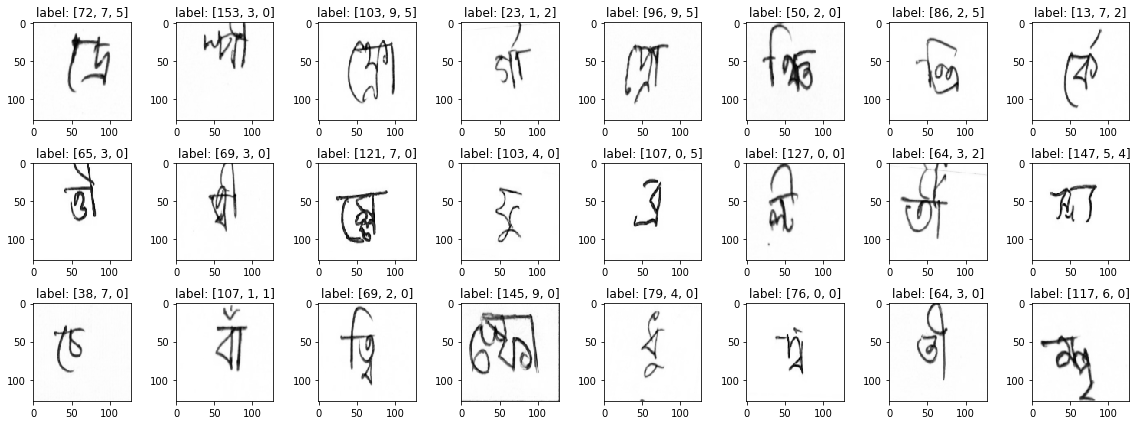

In [12]:
nrow, ncol = 3, 8

fig, axes = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow))
axes = axes.flatten()

for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    ax.imshow(image.reshape((128, 128)), cmap='Greys')
    ax.set_title(f'label: {label.data.tolist()}')

plt.tight_layout()
plt.show()

## Model

In [13]:
import pretrainedmodels
from pretrainedmodels.models.torchvision_models import update_state_dict
from torch import nn
import torch.nn.functional as F

import copy
from sklearn.metrics import recall_score

In [14]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, target, reduction='mean'):
        y_pred = torch.split(y_pred, [n_grapheme, n_vowel, n_consonant], dim=1)
        y_pred = [y_pr.float() for y_pr in y_pred]
        y = target.long()
        
        loss_grapheme = F.cross_entropy(y_pred[0], y[:, 0], reduction=reduction)
        loss_vowel = F.cross_entropy(y_pred[1], y[:, 1], reduction=reduction)
        loss_consonant = F.cross_entropy(y_pred[2], y[:, 2], reduction=reduction)
        final_loss = 0.7 * loss_grapheme + 0.1 * loss_vowel + 0.2 * loss_consonant
        
        return loss_grapheme, loss_vowel, loss_consonant, final_loss

In [15]:
def eval_metric(y_pred, y_fact):
    y_pred = torch.split(y_pred, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in y_pred]

    y_fact = y_fact.cpu().numpy()

    recall_grapheme = recall_score(pred_labels[0], y_fact[:, 0], average='macro', zero_division=0)
    recall_vowel = recall_score(pred_labels[1], y_fact[:, 1], average='macro', zero_division=0)
    recall_consonant = recall_score(pred_labels[2], y_fact[:, 2], average='macro', zero_division=0)
    
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_recall = np.average(scores, weights=[2, 1, 1])

    return recall_grapheme, recall_vowel, recall_consonant, final_recall

In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [17]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    history = {'train_loss_grapheme': list(), 'train_loss_vowel': list(), 'train_loss_consonant': list(), 'train_loss': list(), 
               'train_acc_grapheme': list(), 'train_acc_vowel': list(), 'train_acc_consonant': list(), 'train_acc': list(), 
               'val_loss_grapheme': list(), 'val_loss_vowel': list(), 'val_loss_consonant': list(), 'val_loss': list(), 
               'val_acc_grapheme': list(), 'val_acc_vowel': list(), 'val_acc_consonant': list(), 'val_acc': list(), 
               'lr': list(), 'time': list(), }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    n_plateau_epochs = 1
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        current_lr = get_lr(optimizer)
        try:
            if current_lr < history['lr'][-1]:
                print("LR reduced from {} to {}".format(history['lr'][-1], current_lr))
        except:
            pass
        history['lr'].append(current_lr)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running = {k: 0.0 for k in history.keys()}

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
 
                    outputs = model(inputs)
                    loss_grapheme, loss_vowel, loss_consonant, loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                recall_grapheme, recall_vowel, recall_consonant, final_recall = eval_metric(outputs, labels)
                
                running['{}_loss_grapheme'.format(phase)] += loss_grapheme.item()
                running['{}_loss_vowel'.format(phase)] += loss_vowel.item()
                running['{}_loss_consonant'.format(phase)] += loss_consonant.item()
                running['{}_loss'.format(phase)] += loss.item()
                
                running['{}_acc_grapheme'.format(phase)] += recall_grapheme
                running['{}_acc_vowel'.format(phase)] += recall_vowel
                running['{}_acc_consonant'.format(phase)] += recall_consonant
                running['{}_acc'.format(phase)] += final_recall

            for k in history.keys():
                if phase in k:
                    history[k].append(running[k] / len(dataloaders[phase]))
            
            epoch_loss = history['{}_loss'.format(phase)][-1]
            epoch_acc = history['{}_acc'.format(phase)][-1]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    n_plateau_epochs = 1
                else:
                    n_plateau_epochs += 1

        scheduler.step(epoch_loss)
        history['time'].append((time.time() - epoch_start) / 60)
        print()
        
        if n_plateau_epochs == EARLY_STOP_EPOCHS:
            print(f"Early stopping at {epoch + 1} epoch")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

> Всем привет. Как вы работаете с размером картинок, который не соответствует размеру, на котором обучались сетки? Вы убираете слои, чтобы картинка не свернулась в тензор с отрицательными Height/Width измерениями? Или есть более хороший способ?

> AdaptiveAvgPool вместо обычного

In [18]:
class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

In [19]:
import types

def modify_densenet121(model, n_out=186, drop_prob=0.1):
    # Modify attributs
    model.features.conv0.in_channels = 1
    model.features.conv0.weight.data = model.features.conv0.weight.sum(dim=1, keepdim=True)
    model.last_linear = nn.Linear(in_features=1024, out_features=n_out, bias=True)
    
    del model.classifier

    def logits(self, features):
        x = F.relu(features, inplace=True)
        x = F.adaptive_avg_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

    # Modify methods
    model.logits = types.MethodType(logits, model)
    model.forward = types.MethodType(forward, model)
    return model

def densenet121(num_classes=186, pretrained_path=None, drop_prob=0.1):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    """
    model = torchvision.models.densenet121(pretrained=False)
    if pretrained_path is not None:
        state_dict = update_state_dict(torch.load(pretrained_path))
        model.load_state_dict(state_dict)
    model = modify_densenet121(model, n_out=num_classes, drop_prob=drop_prob)
    return model

In [20]:
class SERES(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d', n_out=186, drop_prob=0.1):
        super(SERES, self).__init__()
        model = pretrainedmodels.__dict__[model_name](pretrained=None)
        pretrained_path = os.popen("find ../input/pytorch-pretrained-models -iname {}*".format(model_name)).read().strip()
        model.load_state_dict(torch.load(pretrained_path))
        
        self.layer0 = model.layer0
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

        self.dropblock0 = DropBlock2D(drop_prob=drop_prob, block_size=7)
        self.dropblock1 = DropBlock2D(drop_prob=drop_prob, block_size=5)
        self.dropblock2 = DropBlock2D(drop_prob=drop_prob, block_size=3)
        self.dropblock3 = DropBlock2D(drop_prob=drop_prob, block_size=3)
        self.dropout = nn.Dropout(drop_prob)
        
#         self.avg_pool = nn.AvgPool2d(kernel_size=4, stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.last_linear = nn.Linear(in_features=2048, out_features=n_out, bias=True)
        
        self.flatten = nn.Flatten()
        
        self.layer0.conv1.in_channels = 1
        self.layer0.conv1.weight.data = self.layer0.conv1.weight.sum(dim=1, keepdim=True)
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.dropblock0(x)
        
        x = self.layer1(x)
        x = self.dropblock1(x)
        
        x = self.layer2(x)
        x = self.dropblock2(x)
        
        x = self.layer3(x)
        x = self.dropblock3(x)
        
        x = self.layer4(x)
    
        x = self.avg_pool(x)
      
        x = self.flatten(x)

        x = self.dropout(x)
        
        out = self.last_linear(x)
        
        return out

In [21]:
def get_optimizer(model_name='se_resnext101_32x4d'):
    if model_name.startswith('se_resnext'):
        optimizer = torch.optim.Adam(
            [
                {"params": model.layer0.parameters()},
                {"params": model.layer1.parameters()},
                {"params": model.layer2.parameters()},
                {"params": model.layer3.parameters()},
                {"params": model.layer4.parameters()},
                {"params": model.last_linear.parameters(), "lr": 0.00003},  # 0.005
            ],
            lr=0.000015,  # 0.001
        )
    elif model_name.startswith('densenet'):
        optimizer = torch.optim.Adam(
            [
                {"params": model.features.parameters()},
                {"params": model.last_linear.parameters(), "lr": 0.005},
            ],
            lr=0.001,
        )
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return optimizer

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

if MODEL_NAME.startswith('se_resnext'):
    model = SERES(model_name=MODEL_NAME, n_out=n_total)
    pretrained_path = '../input/trained-seresnext-70ep/seresnext_v0.1.pt'
    model.load_state_dict(torch.load(pretrained_path, map_location=device))
    
elif MODEL_NAME.startswith('densenet'):
    pretrained_path = os.popen("find ../input/pytorch-pretrained-models -iname {}*".format(MODEL_NAME)).read().strip()
    model = densenet121(pretrained_path=pretrained_path)

model = model.to(device)

In [23]:
grad_params = list()
for name, param in model.named_parameters():
    if param.requires_grad == True:
#         print(name)
        grad_params.append(name)
print("N params:", len(grad_params))

N params: 225


In [24]:
optimizer = get_optimizer(MODEL_NAME)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-10)

In [25]:
criterion = Loss_combine()

In [26]:
# Train and evaluate
model, hist = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

Epoch 1/35
----------
train Loss: 0.0238 Acc: 0.9908
val Loss: 0.0936 Acc: 0.9746

Epoch 2/35
----------
train Loss: 0.0234 Acc: 0.9907
val Loss: 0.0923 Acc: 0.9748

Epoch 3/35
----------
train Loss: 0.0232 Acc: 0.9908
val Loss: 0.0934 Acc: 0.9750

Epoch 4/35
----------
train Loss: 0.0226 Acc: 0.9916
val Loss: 0.0939 Acc: 0.9763

Epoch 5/35
----------
train Loss: 0.0222 Acc: 0.9910
val Loss: 0.0937 Acc: 0.9745

Epoch 6/35
----------
train Loss: 0.0222 Acc: 0.9914
val Loss: 0.0943 Acc: 0.9748

Epoch 7/35
----------
train Loss: 0.0215 Acc: 0.9916
val Loss: 0.0945 Acc: 0.9740

Epoch 8/35
----------
train Loss: 0.0212 Acc: 0.9916
val Loss: 0.0943 Acc: 0.9745

Epoch 9/35
----------
LR reduced from 1.5e-05 to 7.5e-06
train Loss: 0.0233 Acc: 0.9913
val Loss: 0.0947 Acc: 0.9747

Epoch 10/35
----------
train Loss: 0.0215 Acc: 0.9914
val Loss: 0.0945 Acc: 0.9745

Epoch 11/35
----------
train Loss: 0.0220 Acc: 0.9912
val Loss: 0.0946 Acc: 0.9745

Epoch 12/35
----------
train Loss: 0.0217 Acc: 0.9

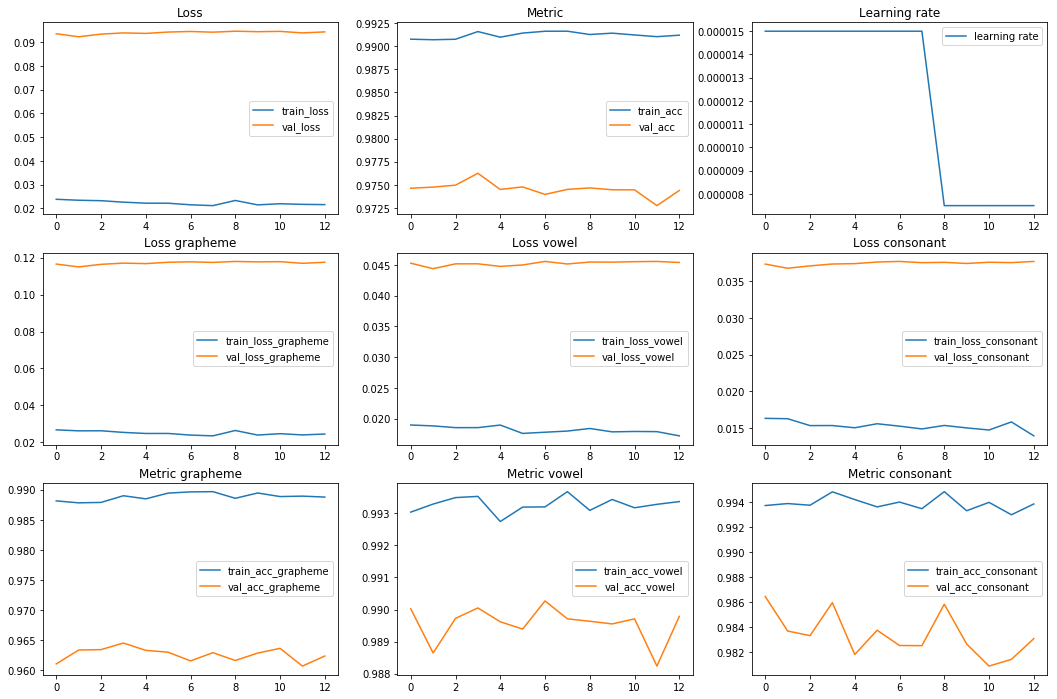

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for phase in ['train', 'val']:
    axes[0, 0].plot(hist[f'{phase}_loss'], label=f'{phase}_loss');
    axes[0, 1].plot(hist[f'{phase}_acc'], label=f'{phase}_acc');
axes[0, 2].plot(hist['lr'], label='learning rate');

axes[0, 0].set_title("Loss");
axes[0, 1].set_title("Metric");
axes[0, 2].set_title("Learning rate");

for i, part in enumerate(['grapheme', 'vowel', 'consonant']):
    for phase in ['train', 'val']:
        axes[1, i].plot(hist[f'{phase}_loss_{part}'], label=f'{phase}_loss_{part}');
        axes[2, i].plot(hist[f'{phase}_acc_{part}'], label=f'{phase}_acc_{part}');
    axes[1, i].set_title(f"Loss {part}");
    axes[2, i].set_title(f"Metric {part}");

for ax in axes.flatten():
    ax.legend();

In [28]:
df = pd.DataFrame(hist)
df.to_csv('./hist.csv')
df

,train_loss_grapheme,train_loss_vowel,train_loss_consonant,train_loss,train_acc_grapheme,train_acc_vowel,train_acc_consonant,train_acc,val_loss_grapheme,val_loss_vowel,val_loss_consonant,val_loss,val_acc_grapheme,val_acc_vowel,val_acc_consonant,val_acc,lr,time
0,0.026668,0.018980,0.016301,0.023826,0.988146,0.993038,0.993745,0.990769,0.116573,0.045292,0.037330,0.093596,0.961011,0.990025,0.986473,0.974630,0.000015,19.847348
1,0.026134,0.018834,0.016253,0.023427,0.987821,0.993289,0.993903,0.990708,0.115036,0.044401,0.036763,0.092318,0.963320,0.988646,0.983718,0.974751,0.000015,14.212202
2,0.026169,0.018552,0.015313,0.023236,0.987891,0.993491,0.993770,0.990761,0.116426,0.045186,0.037084,0.093433,0.963390,0.989725,0.983348,0.974963,0.000015,14.255655
3,0.025284,0.018553,0.015321,0.022619,0.989002,0.993529,0.994840,0.991593,0.117085,0.045193,0.037341,0.093947,0.964484,0.990050,0.985982,0.976250,0.000015,14.118135
4,0.024704,0.018973,0.015018,0.022194,0.988487,0.992745,0.994223,0.990986,0.116828,0.044770,0.037392,0.093735,0.963264,0.989619,0.981841,0.974497,0.000015,14.175169
5,0.024709,0.017610,0.015566,0.022170,0.989442,0.993194,0.993638,0.991429,0.117550,0.045005,0.037610,0.094308,0.962958,0.989392,0.983782,0.974772,0.000015,14.129751
6,0.023829,0.017806,0.015236,0.021508,0.989644,0.993201,0.994023,0.991628,0.117789,0.045579,0.037692,0.094548,0.961511,0.990269,0.982559,0.973962,0.000015,14.226554
7,0.023415,0.017995,0.014859,0.021161,0.989682,0.993676,0.993492,0.991633,0.117474,0.045165,0.037524,0.094253,0.962879,0.989710,0.982547,0.974504,0.000015,14.203175
8,0.026318,0.018413,0.015334,0.023330,0.988576,0.993093,0.994854,0.991275,0.118005,0.045480,0.037568,0.094665,0.961578,0.989635,0.985860,0.974663,0.000008,14.411690
9,0.023843,0.017867,0.014998,0.021476,0.989461,0.993432,0.993329,0.991421,0.117755,0.045464,0.037415,0.094458,0.962812,0.989552,0.982679,0.974464,0.000008,14.170175


In [29]:
model_path = os.path.join(OUT_PATH, f'{MODEL_NAME}_v0.2.pt')
torch.save(model.state_dict(), model_path)